# Repeated measure ANOVA for short-term

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
import json

In [ ]:
# Load the uploaded CSV data
file_path = 'questionnaire/short_term/response_summary_short.csv'
data = pd.read_csv(file_path)

# Extract unique strategies
strategies = data['strategy'].unique()

# Initialize dictionary to store ANOVA results and means of method 0 and method 1
results = {}

# Prepare subplots for combined visualization
columns = ['cognitive_load', 'enjoyment']
fig, axs = plt.subplots(len(columns), 1, figsize=(12, 5 * len(columns)))
axes = axs.flatten()

# Iterate over each column of interest
for i, column in enumerate(columns):
    results[column] = {}
    
    # Prepare data for plotting and analysis
    combined_data = []
    labels = []

    for strategy in strategies:
        # # Correction
        # if strategy == 'LC':
        #     strategy = 'IC'
        strategy_data = data[data['strategy'] == strategy]
        
         # Reformat the data for ANOVA
        long_format_data = pd.melt(strategy_data, id_vars=['participant', 'strategy', 'method'], value_vars=[column],
                                  var_name='variable', value_name='value')
        
        # Perform Repeated Measures ANOVA
        model = AnovaRM(long_format_data, 'value', 'participant', within=['method'])
        fit_result = model.fit()
        results[column][strategy] = fit_result
        
        # Prepare data for boxplot
        combined_data.append(strategy_data[strategy_data['method'] == 0][column].values)
        combined_data.append(strategy_data[strategy_data['method'] == 1][column].values)
        labels.append(f'{strategy} (Method 0)')
        labels.append(f'{strategy} (Method 1)')
        
        # Get p-value
        p_value = fit_result.anova_table['Pr > F'][0]
        
        # Determine number of asterisks
        if p_value < 0.05:
            num_asterisks = 2
        elif p_value < 0.1:
            num_asterisks = 1
        else:
            num_asterisks = 0
        
        # Add asterisks to the plot
        if num_asterisks > 0:
            y_max = max(strategy_data[strategy_data['method'] == 1][column].values)
            axes[i].text(len(combined_data), y_max, '*' * num_asterisks, color='red', ha='center')

    # Plotting combined boxplot for each column
    axes[i].boxplot(combined_data, labels=labels, patch_artist=True)
    axes[i].set_title(f'{column.capitalize()} across all Strategies')
    axes[i].set_xlabel('Strategy and Method')
    axes[i].set_ylabel(column.capitalize())
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM

# Load the uploaded CSV data
file_path = 'questionnaire/short_term/response_summary_short.csv'
data = pd.read_csv(file_path)

# Define font
font = 'Calibri'

# Define the desired order of strategies
strategies = ['IL', 'RQ', 'AN', 'LC', 'TP', 'EE']

# Initialize dictionary to store ANOVA results and means of method 0 and method 1
results = {}

# Define colors for each strategy
colors = {
    'IC': '#D8CEF2',
    'RQ': '#FFDCA6',
    'AN': '#FBF2A3',
    'PL': '#FFC3BF',
    'CT': '#CAEDF2',
    'EE': '#D8FCAA'
}

# Function to create and save a plot for given columns
def create_and_save_plots(columns, file_name):
    fig, axs = plt.subplots(len(columns), 1, figsize=(12, 10), sharex=True)
    
    for i, column in enumerate(columns):
        ax = axs[i]
        combined_data = []
        labels = []
        box_colors = []
        positions = []

        for idx, strategy in enumerate(strategies):
            strategy_data = data[data['strategy'] == strategy]
            
            # Reformat the data for ANOVA
            long_format_data = pd.melt(strategy_data, id_vars=['participant', 'strategy', 'method'], value_vars=[column],
                                      var_name='variable', value_name='value')
            
            # Perform Repeated Measures ANOVA
            model = AnovaRM(long_format_data, 'value', 'participant', within=['method'])
            fit_result = model.fit()
            results[column] = fit_result
            
            # Prepare data for boxplot
            combined_data.append(strategy_data[strategy_data['method'] == 0][column].values)
            combined_data.append(strategy_data[strategy_data['method'] == 1][column].values)
            # if strategy == 'LC':
            #     strategy = 'IC'
            name_mapping = {
                'IL': 'PL',
                'RQ': 'RQ',
                'AN': 'AN',
                'LC': 'IC',
                'TP': 'CT',
                'EE': 'EE'
            }
            strategy = name_mapping[strategy]

            labels.append(f'{strategy} (w\\o strategy)')
            labels.append(f'{strategy} (w\\ strategy)')
            box_colors.append(colors[strategy])
            box_colors.append(colors[strategy])
            
            # Set custom positions to reduce the gap
            positions.append(idx * 2)
            positions.append(idx * 2 + 0.8)
            
            # Get p-value
            p_value = fit_result.anova_table['Pr > F'].iloc[0]
            
            # Determine number of asterisks
            if p_value < 0.05:
                num_asterisks = 2
            elif p_value < 0.1:
                num_asterisks = 1
            else:
                num_asterisks = 0
            
            # Add asterisks to the plot
            if num_asterisks > 0:
                y_max = max(strategy_data[strategy_data['method'] == 1][column].values)
                ax.text(positions[-1], y_max, '*' * num_asterisks, color='red', ha='center', fontsize=24)

        # Plotting combined boxplot for the column
        boxplot = ax.boxplot(combined_data, labels=labels, patch_artist=True, positions=positions)
        
        # Set colors for each box
        for patch, color in zip(boxplot['boxes'], box_colors):
            patch.set_facecolor(color)
        
        # Change the median line color to black
        for median in boxplot['medians']:
            median.set_color('black')
        
        if column == 'cognitive_load':
            title_word = 'Cognitive Load'
        else:
            title_word = column.capitalize()
        
        # ax.set_title(f'{title_word} across Strategies')
        if column == 'cognitive_load':
            ax.set_xlabel('(a)', fontsize=16, fontname=font)
        else:
            ax.set_xlabel('(b)', fontsize=16, fontname=font)
        ax.set_ylabel(title_word, fontsize=18, fontname=font)
        ax.tick_params(axis='x', rotation=45)

    # Set the shared x-axis label
    fig.text(0.5, 0.04, 'Strategy', ha='center', va='center', fontsize=18, fontname=font)
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    # plt.show()
    
    # Save the plot as a PDF file
    plt.savefig(file_name)
    plt.close()

# Create and save plots for the specified columns
create_and_save_plots(['cognitive_load', 'enjoyment'], 'figs/short_term_plots.png')

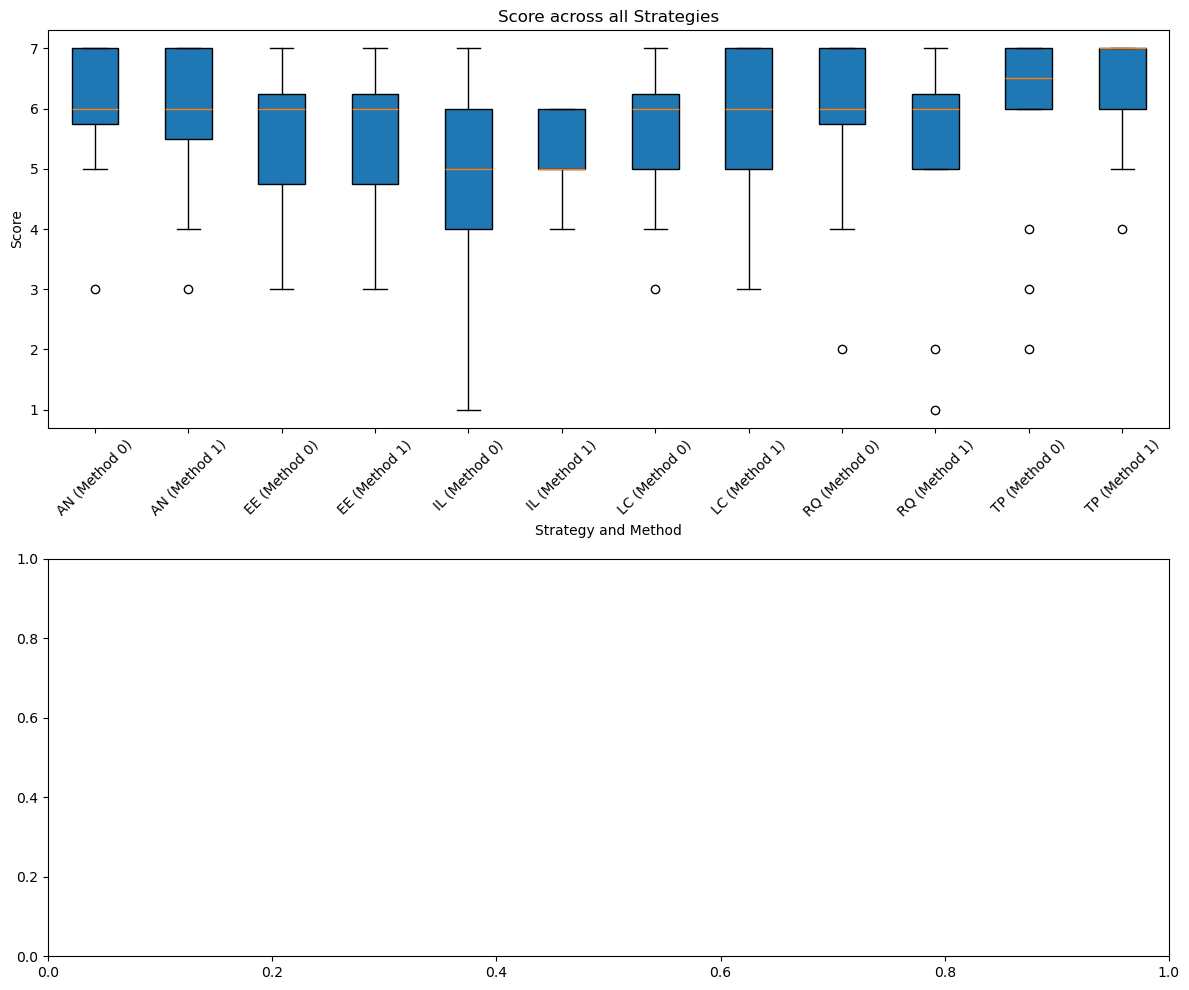

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Load the uploaded CSV data
file_path = 'questionnaire/short_term/response_summary_short.csv'
data = pd.read_csv(file_path)

# Extract unique strategies
strategies = data['strategy'].unique()

# Initialize dictionary to store Wilcoxon test results and means of method 0 and method 1
results = {}

# Prepare subplots for combined visualization
columns = ['score']

fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axes = axs.flatten()

# Iterate over each column of interest
for i, column in enumerate(columns):
    results[column] = {}
    
    # Prepare data for plotting and analysis
    combined_data = []
    labels = []

    for strategy in strategies:
        strategy_data = data[data['strategy'] == strategy]
        
        # Prepare data for Wilcoxon test
        method_0_data = strategy_data[strategy_data['method'] == 0][column].values
        method_1_data = strategy_data[strategy_data['method'] == 1][column].values
        
        # Perform Wilcoxon test
        wilcoxon_result = wilcoxon(method_0_data, method_1_data)
        results[column][strategy] = wilcoxon_result
        
        # Prepare data for boxplot
        combined_data.append(method_0_data)
        combined_data.append(method_1_data)
        labels.append(f'{strategy} (Method 0)')
        labels.append(f'{strategy} (Method 1)')
        
        # Get p-value
        p_value = wilcoxon_result.pvalue
        
        # Determine number of asterisks
        if p_value < 0.01:
            num_asterisks = 3
        elif p_value < 0.05:
            num_asterisks = 2
        elif p_value < 0.1:
            num_asterisks = 1
        else:
            num_asterisks = 0
        
        # Add asterisks to the plot
        if num_asterisks > 0:
            y_max = max(method_1_data)
            axes[i].text(len(combined_data), y_max, '*' * num_asterisks, color='red', ha='center')

    # Plotting combined boxplot for each column
    axes[i].boxplot(combined_data, labels=labels, patch_artist=True)
    axes[i].set_title(f'{column.capitalize()} across all Strategies')
    axes[i].set_xlabel('Strategy and Method')
    axes[i].set_ylabel(column.capitalize())
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [14]:
# Display the combined results dictionary with means and ANOVA results
anova_results = {}
for column, strategy_results in results.items():
    anova_results[column] = {}
    for strategy, result in strategy_results.items():
        anova_results[column][strategy] = {
            'mean_method0': data[(data['strategy'] == strategy) & (data['method'] == 0)][column].mean(),
            'mean_method1': data[(data['strategy'] == strategy) & (data['method'] == 1)][column].mean(), 
            'F-value': result.anova_table['F Value'][0],
            'p-value': result.anova_table['Pr > F'][0]
        }

# Save the results to a JSON file
with open('questionnaire/short_term/anova_results_short.json', 'w') as f:
    json.dump(anova_results, f, indent=4)

C:\Users\hu\AppData\Local\Temp\ipykernel_13460\4223200725.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'F-value': result.anova_table['F Value'][0],
C:\Users\hu\AppData\Local\Temp\ipykernel_13460\4223200725.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p-value': result.anova_table['Pr > F'][0]


## Single question

In [ ]:
# Load the uploaded CSV data
file_path = 'questionnaire/short_term/response_summary_short.csv'
data = pd.read_csv(file_path)

# Extract unique strategies
strategies = data['strategy'].unique()

# Initialize dictionary to store ANOVA results and means of method 0 and method 1
results = {}

# Prepare subplots for combined visualization
columns = ['competence', 'mental_demand', 'frustration', 'pleasure',
           'temporal_demand', 'effort', 'lost_track', 'physical_effort', 
           'difficulty', 'familiarity', 'understanding']

fig, axs = plt.subplots(len(columns), 1, figsize=(12, 5 * len(columns)))
axes = axs.flatten()

# Iterate over each column of interest
for i, column in enumerate(columns):
    results[column] = {}
    
    # Prepare data for plotting and analysis
    combined_data = []
    labels = []

    for strategy in strategies:
        # # Correction
        # if strategy == 'LC':
        #     strategy = 'IC'
        strategy_data = data[data['strategy'] == strategy]
        
         # Reformat the data for ANOVA
        long_format_data = pd.melt(strategy_data, id_vars=['participant', 'strategy', 'method'], value_vars=[column],
                                  var_name='variable', value_name='value')
        
        # Perform Repeated Measures ANOVA
        model = AnovaRM(long_format_data, 'value', 'participant', within=['method'])
        fit_result = model.fit()
        results[column][strategy] = fit_result
        
        # Prepare data for boxplot
        combined_data.append(strategy_data[strategy_data['method'] == 0][column].values)
        combined_data.append(strategy_data[strategy_data['method'] == 1][column].values)
        labels.append(f'{strategy} (Method 0)')
        labels.append(f'{strategy} (Method 1)')
        
        # Get p-value
        p_value = fit_result.anova_table['Pr > F'][0]
        
        # Determine number of asterisks
        if p_value < 0.01:
            num_asterisks = 3
        elif p_value < 0.05:
            num_asterisks = 2
        elif p_value < 0.1:
            num_asterisks = 1
        else:
            num_asterisks = 0
        
        # Add asterisks to the plot
        if num_asterisks > 0:
            y_max = max(strategy_data[strategy_data['method'] == 1][column].values)
            axes[i].text(len(combined_data), y_max, '*' * num_asterisks, color='red', ha='center')

    # Plotting combined boxplot for each column
    axes[i].boxplot(combined_data, labels=labels, patch_artist=True)
    axes[i].set_title(f'{column.capitalize()} across all Strategies')
    axes[i].set_xlabel('Strategy and Method')
    axes[i].set_ylabel(column.capitalize())
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

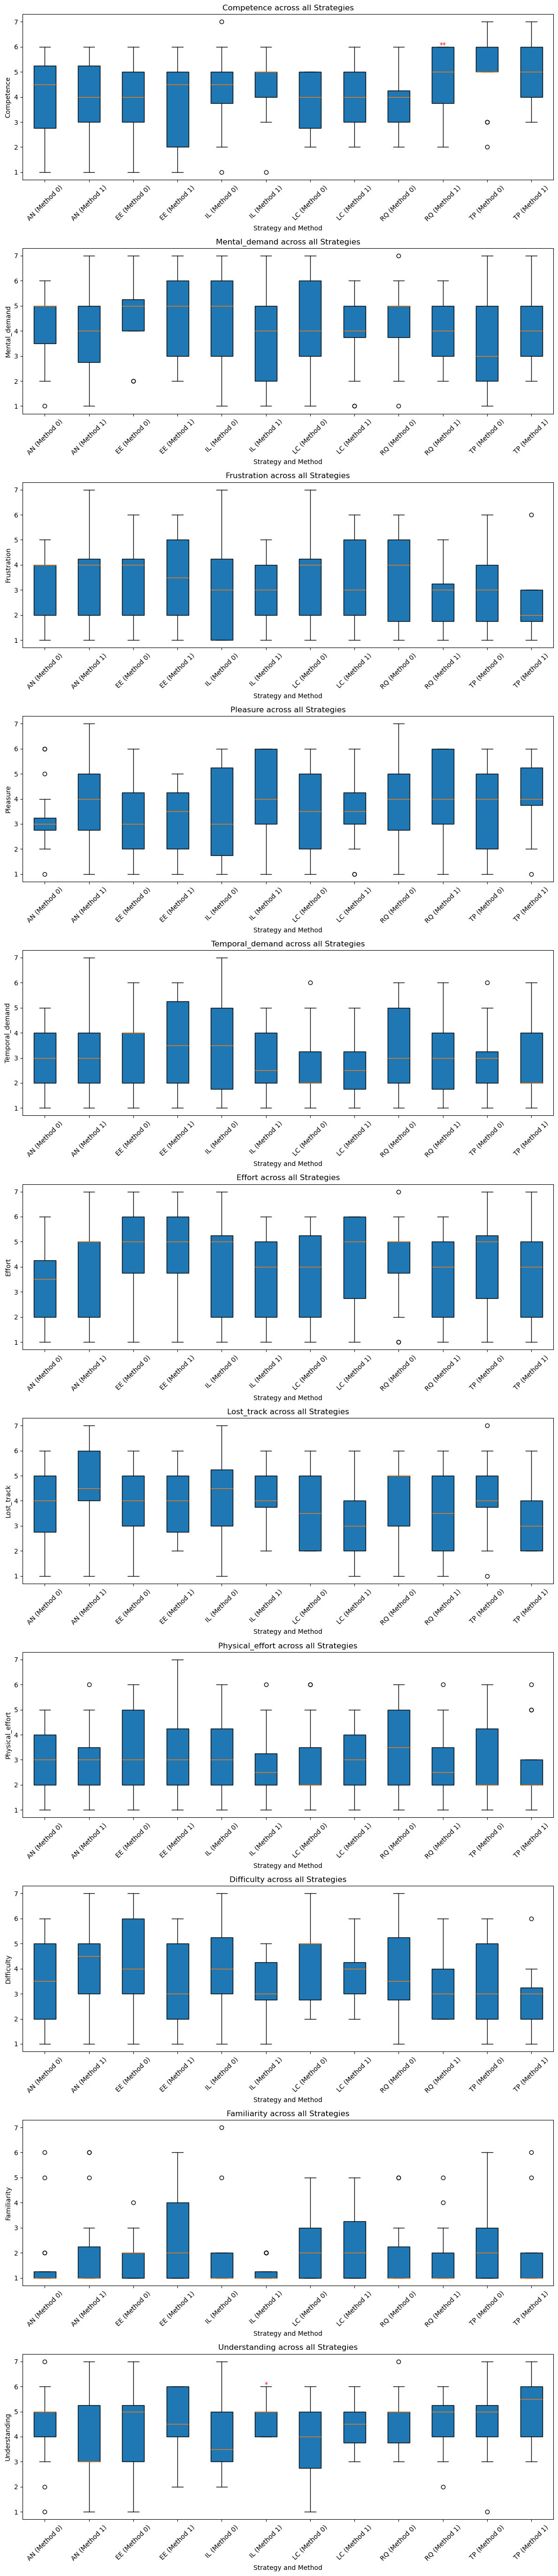

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Load the uploaded CSV data
file_path = 'questionnaire/short_term/response_summary_short.csv'
data = pd.read_csv(file_path)

# Extract unique strategies
strategies = data['strategy'].unique()

# Initialize dictionary to store Wilcoxon test results and means of method 0 and method 1
results = {}

# Prepare subplots for combined visualization
columns = ['competence', 'mental_demand', 'frustration', 'pleasure',
           'temporal_demand', 'effort', 'lost_track', 'physical_effort', 
           'difficulty', 'familiarity', 'understanding']

fig, axs = plt.subplots(len(columns), 1, figsize=(12, 5 * len(columns)))
axes = axs.flatten()

# Iterate over each column of interest
for i, column in enumerate(columns):
    results[column] = {}
    
    # Prepare data for plotting and analysis
    combined_data = []
    labels = []

    for strategy in strategies:
        strategy_data = data[data['strategy'] == strategy]
        
        # Prepare data for Wilcoxon test
        method_0_data = strategy_data[strategy_data['method'] == 0][column].values
        method_1_data = strategy_data[strategy_data['method'] == 1][column].values
        
        # Perform Wilcoxon test
        wilcoxon_result = wilcoxon(method_0_data, method_1_data)
        results[column][strategy] = wilcoxon_result
        
        # Prepare data for boxplot
        combined_data.append(method_0_data)
        combined_data.append(method_1_data)
        labels.append(f'{strategy} (Method 0)')
        labels.append(f'{strategy} (Method 1)')
        
        # Get p-value
        p_value = wilcoxon_result.pvalue
        
        # Determine number of asterisks
        if p_value < 0.01:
            num_asterisks = 3
        elif p_value < 0.05:
            num_asterisks = 2
        elif p_value < 0.1:
            num_asterisks = 1
        else:
            num_asterisks = 0
        
        # Add asterisks to the plot
        if num_asterisks > 0:
            y_max = max(method_1_data)
            axes[i].text(len(combined_data), y_max, '*' * num_asterisks, color='red', ha='center')

    # Plotting combined boxplot for each column
    axes[i].boxplot(combined_data, labels=labels, patch_artist=True)
    axes[i].set_title(f'{column.capitalize()} across all Strategies')
    axes[i].set_xlabel('Strategy and Method')
    axes[i].set_ylabel(column.capitalize())
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [5]:
# Display the combined results dictionary with means and ANOVA results
ques_results = {}
for column, strategy_results in results.items():
    ques_results[column] = {}
    for strategy, result in strategy_results.items():
        ques_results[column][strategy] = {
            'mean_method0': data[(data['strategy'] == strategy) & (data['method'] == 0)][column].mean(),
            'mean_method1': data[(data['strategy'] == strategy) & (data['method'] == 1)][column].mean(), 
            'F-value': result.anova_table['F Value'][0],
            'p-value': result.anova_table['Pr > F'][0]
        }

# Save the results to a JSON file
with open('questionnaire/short_term/questions_results_short.json', 'w') as f:
    json.dump(ques_results, f, indent=4)

C:\Users\hu\AppData\Local\Temp\ipykernel_38100\3846712428.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'F-value': result.anova_table['F Value'][0],
C:\Users\hu\AppData\Local\Temp\ipykernel_38100\3846712428.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p-value': result.anova_table['Pr > F'][0]


### Familiarity of topics

In [ ]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load the uploaded CSV data
file_path = 'questionnaire/short_term/response_summary_short.csv'
data = pd.read_csv(file_path)

# Extract the relevant columns for ANOVA
# Assuming 'familiarity' is the column with familiarity scores and 'topic' is the categorical variable
topics = data['topic'].unique()
familiarity_scores = [data[data['topic'] == topic]['familiarity'] for topic in topics]

# Perform the one-way ANOVA test
f_statistic, p_value = f_oneway(*familiarity_scores)

# Print the results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There are significant differences in familiarity between topics.")
    
    # Perform Tukey's HSD test
    tukey = pairwise_tukeyhsd(endog=data['familiarity'], groups=data['topic'], alpha=0.05)
    print(tukey)
else:
    print("There are no significant differences in familiarity between topics.")